# 说明：

（1）过拟合：
查看过拟合，要查看的是模型训练过程中的“**测试数据**”！而不是看“**训练数据**”。 —— 画图后看：
- 测试数据与训练数据的Loss对比图；—— 训练loss不断下降，测试loss基本不降！
- 测试数据与训练数据的acc对比图；—— 训练acc不断上升，测试acc基本不升！

只要两条对比线之间有巨大的差距，并且没有缩小差距的趋势，那就是过拟合了。

所以modol.fit()中要多加一个validation_data参数 —— 相当于在每个epoch训练后进行一次model.evaluate()的模型评估！

（2）欠拟合：
- 训练数据、测试数据上的得分**都不高**！只会说明当前网络的拟合能力都不够！
- 测试数据的得分要比训练数据高（泛化能力很强）！说明当前网络的拟合精度可以再调高一些 —— 一般都是dropout太多了！

---

Dropout的注意：随机丢弃（**本次不更新，不是删了**！）
- 类似随机森林；
- 每个epoch的随机丢弃情况，基本都是不同的（因为随机）！—— 正传设定丢弃谁，反传时被丢弃的神经元的**相关参数不被更新**！—— 更新不同步！
- 预测时还是用最终的全网络（因为本质上没有删除谁，只是有些神经元的参数更新相比别人**滞后了**）。

好处：
- 权值的更新，不再仅依赖具有固定关系的隐藏神经元间的相互作用，这样就阻止了：**某些不重要的特征**仅仅在其他特定特征下才会有效果的情况。

说明：
- dropout仅仅是抑制过拟合的一种方法；减少epoch、正则化都可以；
- 抑制过拟合最好方法：1. 增多训练数据；2. 将网络容量减小（dropout属于其中一种，将每层的神经元减小），已知：层数影响 > 每层神经元数影响 —— 用小网络（层数少）很难过拟合，因为学习能力有限，它只能先把最明显、最大最广的特征学到。

---

神经网络的修正思路-调参：**容易测试集泄漏（注意使用交叉验证）！**
- 先达到过拟合，无限提高拟合能力（网络容量没问题）：1. 添加更多的层；2. 每一层单元增多；3. 训练更多的epoch；
- 抑制过拟合，增加网络泛化能力（大调）：1. Dropout层；2. **正则化**；3. 图像增强； —— 但：最好的方法是增多训练数据。
- 不过拟合后，再微调网络使得拟合能力再提高一点（容量稍微增大）：1. 改变学习速率；2. 改变Dropout中隐藏单元的数量；3. 改变epoch的值；
- 再重复上述3个过程。

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 加载数据集:
(train_image, train_label), (test_image, test_label) = tf.keras.datasets.fashion_mnist.load_data()

# 归一化：
train_image = train_image / 255
test_image = test_image / 255

# 把标签进独热编码：
train_label_onehot = tf.keras.utils.to_categorical(train_label)
test_label_onehot = tf.keras.utils.to_categorical(test_label)

# 过拟合效果：

In [3]:
model = tf.keras.Sequential()

# 多加几层：大容量网络
model.add( tf.keras.layers.Flatten( input_shape = (28,28) ) )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dense(10, activation = 'softmax') )  

In [4]:
# 还用优化器的默认参数：
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['acc'] 
)

In [5]:
# 加validation_data：看每个epoch训练后，当前网络模型的表现 
history = model.fit( train_image, train_label_onehot, epochs = 10, validation_data = (test_image,test_label_onehot) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.4845 - acc: 0.8235 - val_loss: 0.4033 - val_acc: 0.8513
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3645 - acc: 0.8657 - val_loss: 0.3713 - val_acc: 0.8640
Epoch 3/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3337 - acc: 0.8770 - val_loss: 0.4060 - val_acc: 0.8577
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3110 - acc: 0.8845 - val_loss: 0.3696 - val_acc: 0.8695
Epoch 5/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2930 - acc: 0.8901 - val_loss: 0.3521 - val_acc: 0.8703
Epoch 6/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2803 - acc: 0.8960 - val_loss: 0.3409 - val_acc: 0.8748
Epoch 7/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.2667 - acc: 0.8992 - val_loss: 0.

In [8]:
# 看看现在有哪些键：
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

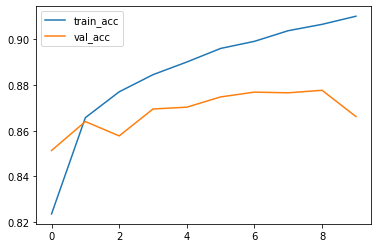

In [6]:
# 画图对比：acc变化
plt.plot(history.epoch, history.history.get('acc'), label = 'train_acc')
plt.plot(history.epoch, history.history.get('val_acc'), label = 'val_acc')
plt.legend()
# 在测试数据上精度acc不升反降！很明显的过拟合！

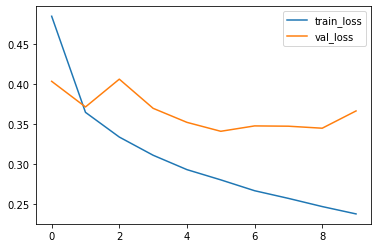

In [7]:
# 画图对比：loss
plt.plot(history.epoch, history.history.get('loss'), label = 'train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'val_loss')
plt.legend()
# 在测试数据上Loss最后反而上升！明显的过拟合！

说明：不管是acc对比，还是loss对比；两条线之间都有较大的鸿沟，并且没有明显的缩小趋势。 —— 过拟合。

# Dropout抑制过拟合：

In [8]:
model = tf.keras.Sequential()

# 仍用同样的大网络：加入Dropout层！
model.add( tf.keras.layers.Flatten( input_shape = (28,28) ) )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dropout(0.5) )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dropout(0.5) )
model.add( tf.keras.layers.Dense(128, activation = 'relu') )
model.add( tf.keras.layers.Dropout(0.5) )
model.add( tf.keras.layers.Dense(10, activation = 'softmax') )  

In [9]:
# 还用优化器的默认参数：
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['acc'] 
)

In [10]:
history = model.fit( train_image, train_label_onehot, epochs = 10, validation_data = (test_image,test_label_onehot) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.8536 - acc: 0.6827 - val_loss: 0.5397 - val_acc: 0.7962
Epoch 2/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.6117 - acc: 0.7834 - val_loss: 0.4893 - val_acc: 0.8316
Epoch 3/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.5647 - acc: 0.8005 - val_loss: 0.4467 - val_acc: 0.8406
Epoch 4/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.5433 - acc: 0.8080 - val_loss: 0.4251 - val_acc: 0.8430
Epoch 5/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.5276 - acc: 0.8142 - val_loss: 0.4348 - val_acc: 0.8463
Epoch 6/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.5135 - acc: 0.8191 - val_loss: 0.4241 - val_acc: 0.8471
Epoch 7/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.5028 - acc: 0.8240 - val_loss: 0.

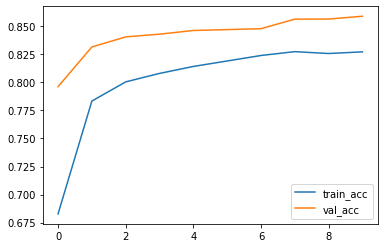

In [13]:
# 画图对比：acc
plt.plot(history.epoch, history.history.get('acc'), label = 'train_acc')
plt.plot(history.epoch, history.history.get('val_acc'), label = 'val_acc')
plt.legend()
# dropout过多，有点欠拟合了：测试数据得分比训练数据高 —— 泛化能力 > 拟合能力

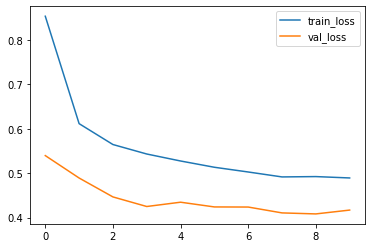

In [12]:
# 画图对比：loss
plt.plot(history.epoch, history.history.get('loss'), label = 'train_loss')
plt.plot(history.epoch, history.history.get('val_loss'), label = 'val_loss')
plt.legend()